# Spatial Indexing with PostgreSQL & Q3C

ER 11/14/2017

Connect the test database and extract all sources from the 6GHz.0217+738.IPln1.fits image

In [1]:
import psycopg2
import psycopg2.extras

conn = psycopg2.connect(host='localhost', database='test', user='erichards')
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [2]:
cur.execute('SELECT q3c_version()')
print(cur.fetchone())

['1.5.0']


In [3]:
cur.execute('SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2')
allsrcs = cur.fetchall()
print len(allsrcs), allsrcs

44 [[0, 41.039, 73.7914], [1, 41.0589, 73.8881], [2, 40.2936, 72.0361], [3, 39.8224, 72.661], [4, 39.889, 72.9225], [5, 39.6059, 72.4295], [6, 39.0879, 73.9505], [7, 38.6175, 72.958], [8, 39.0635, 75.1031], [9, 38.3664, 72.53], [10, 38.4858, 73.202], [11, 37.5215, 72.7633], [12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [19, 35.0742, 72.2214], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [28, 32.4657, 72.4905], [29, 32.2065, 74.0724], [30, 32.0597, 72.1139], [31, 31.4079, 75.3685], [32, 31.2676, 73.6094], [33, 31.1963, 73.1645], [34, 30.9672, 73.9812], [35, 30.5499, 73.4629], [36, 29.9211, 74.8912], [37, 29.5749, 74.6342], [38, 29.394, 74.7119], [39, 29.5255, 74.3054], [40, 29.5095, 74.3164], [41, 29.5022, 73.9371], [42, 29.13

In [4]:
for src in allsrcs[:3]:
    print src['src_id'], src['ra'], src['dec']

0 41.039 73.7914
1 41.0589 73.8881
2 40.2936 72.0361


In [5]:
import dbclasses

assoc_objects = []
for src in allsrcs[:3]:
    assoc_objects.append(dbclasses.AssociatedSource())
    dbclasses.dict2attr(assoc_objects[-1], src)
    
print assoc_objects[0].__dict__

{'total_flux_islE': None, 'isl_id': None, 'code': None, 'match_id': None, 'resid_rms': None, 'e_dec': None, 'rms_isl': None, 'dc_pa': None, 'dc_min': None, 'src_id': 0, 'min': None, 'ndetect': None, 'nopp': None, 'e_dec_max': None, 'assoc_id': None, 'pa': None, 'ra': 41.039, 'e_peak_flux': None, 'e_ra': None, 'e_pa': None, 'ra_max': None, 'min_deRuiter': None, 'e_dc_maj': None, 'image_id': None, 'dec_max': None, 'total_flux_isl': None, 'e_ra_max': None, 'e_dc_pa': None, 'maj': None, 'dc_maj': None, 'total_flux': None, 'resid_mean': None, 'beam': None, 'mean_isl': None, 'e_maj': None, 'peak_flux': None, 'e_min': None, 'e_total_flux': None, 'catalog_id': None, 'dec': 73.7914, 'e_dc_min': None}


Extract the image header and WCS

In [6]:
from astropy.io import fits
from astropy.wcs import WCS

data, hdr = fits.getdata('../test/2017-08/30/Images/6GHz.0217+738.IPln1.fits', header=True)
w = WCS(hdr).celestial
print w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 34.378387495829998  73.825727777500006  
CRPIX : 2169.0  2169.0  
NAXIS    : 4337 4337


Function to define the box in which sources will be extracted

In [7]:
import numpy as np

In [8]:
def search_box(naxis1, naxis2, scale, wcs):
    """Defines corner coordinates of the box in
    which to search for sources. The size of the box
    is calculated as a fraction of the axis lengths
    in pixels. Pixel coordinates are translated to
    RA & Dec using the WCS method wcs_pix2world().
    The calculation is done using pixels for two reasons:
    
    1.) the size of the box in which to look for sources
    used by PyBDSF must be defined in pixels (trim_box)
    
    2.) attempts to compute this box using the angular 
    FOV and center RA, Dec coordinates yields different
    results, which look wrong when overlaid on the image
    in ds9. I have no idea why this is the case.
    
    """
    n1sc = int(naxis1 * scale)
    n2sc = int(naxis2 * scale)
    n1diff = naxis1 - n1sc
    n2diff = naxis2 - n2sc
    # pixel edges start at 0.5, center is at 1.0, and other edge at 1.5
    # corners listed starting at BLC and go clockwise
    corners = np.array([[n1diff + 0.5, n2diff + 0.5],
                        [n1diff + 0.5, n2sc + 0.5],
                        [n1sc + 0.5, n2sc + 0.5],
                        [n1sc + 0.5, n2diff + 0.5]])
    box = wcs.wcs_pix2world(corners, 1)
    return box

Check that the search_box function returns the same coordinates as the footprint function

In [9]:
box = search_box(hdr['NAXIS1'], hdr['NAXIS2'], 1., w)
fp = w.calc_footprint()

In [10]:
box

array([[ 43.44539558,  70.59580201],
       [ 47.33792703,  76.49925207],
       [ 21.41884796,  76.49925207],
       [ 25.31137941,  70.59580201]])

In [11]:
fp

array([[ 43.44364513,  70.59659188],
       [ 47.33438235,  76.49872552],
       [ 21.42239264,  76.49872552],
       [ 25.31312986,  70.59659188]])

## Extracting sources without indexing

This is how all sources within a box size 65% of the total footprint size would be extracted using RA & Dec alone.

In [12]:
box65 = search_box(hdr['NAXIS1'], hdr['NAXIS2'], 0.65, w)
boxsize = box65[1,1] - box65[0,1]
box65, boxsize

(array([[ 37.44066008,  72.90272281],
        [ 37.79059428,  74.69988328],
        [ 30.96618071,  74.69988328],
        [ 31.31611492,  72.90272281]]), 1.797160473179062)

In [13]:
sql = (
    '''
    CREATE OR REPLACE FUNCTION alpha(theta real, decl real)
      RETURNS real AS 
    $$
    BEGIN
      IF ABS(decl) + theta > 89.9 THEN 
        RETURN 180;
      ELSE
        RETURN DEGREES(ABS(ATAN(SIN(RADIANS(theta)) / SQRT(ABS(COS(RADIANS(decl - theta)) * COS(RADIANS(decl + theta))))))); 
      END IF;
    END; $$
    LANGUAGE plpgsql;
    ''')

In [14]:
try:
    cur.execute(sql)
    conn.commit()
except:
    conn.rollback()
    cur.execute(sql)
    conn.commit()

In [15]:
query = '''SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2 AND
    dec BETWEEN %s AND %s AND ra BETWEEN %s-alpha(%s, dec) AND %s+alpha(%s, dec)'''

In [16]:
theta = boxsize / 2.
theta

0.89858023658953101

In [17]:
try:
    cur.execute(query, (box65[0,1], box65[1,1], hdr['OBSRA'], theta, hdr['OBSRA'], theta))
    srcs = cur.fetchall()
except:
    conn.rollback()
    cur.execute(query, (box65[0,1], box65[1,1], hdr['OBSRA'], theta, hdr['OBSRA'], theta))
    srcs = cur.fetchall()

print len(srcs), srcs

17 [[12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [29, 32.2065, 74.0724], [32, 31.2676, 73.6094]]


In [18]:
with open('../test/2017-08/30/Images/pgsearchb65.reg', 'w') as f:
    f.write('global color=green\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

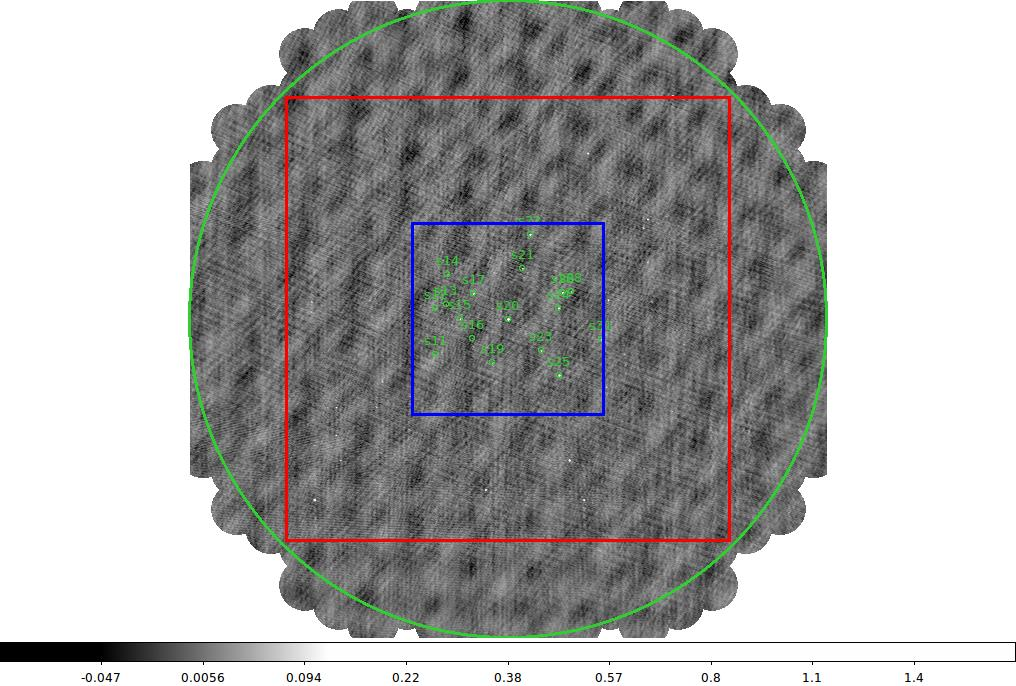

In [19]:
from IPython.display import Image
Image(filename='../test/2017-08/30/Images/pgb65srcs.jpeg')

Success!

## Extracting sources using Q3C spatial indexing

The table is indexed on RA & Dec at creation.

In [20]:
query = '''SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2 AND
    q3c_poly_query(ra, dec, '{%s, %s, %s, %s, %s, %s, %s, %s}')'''

In [21]:
box65

array([[ 37.44066008,  72.90272281],
       [ 37.79059428,  74.69988328],
       [ 30.96618071,  74.69988328],
       [ 31.31611492,  72.90272281]])

In [22]:
try:
    cur.execute(query, (box65[0,0], box65[0,1], box65[1,0], box65[1,1], box65[2,0], box65[2,1], box65[3,0], box65[3,1]))
    srcs = cur.fetchall()
except:
    conn.rollback()
    cur.execute(query, (box65[0,0], box65[0,1], box65[1,0], box65[1,1], box65[2,0], box65[2,1], box65[3,0], box65[3,1]))
    srcs = cur.fetchall()

print len(srcs), srcs

17 [[12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [29, 32.2065, 74.0724], [32, 31.2676, 73.6094]]


In [23]:
with open('../test/2017-08/30/Images/q3csearchb65.reg', 'w') as f:
    f.write('global color=blue width=2\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

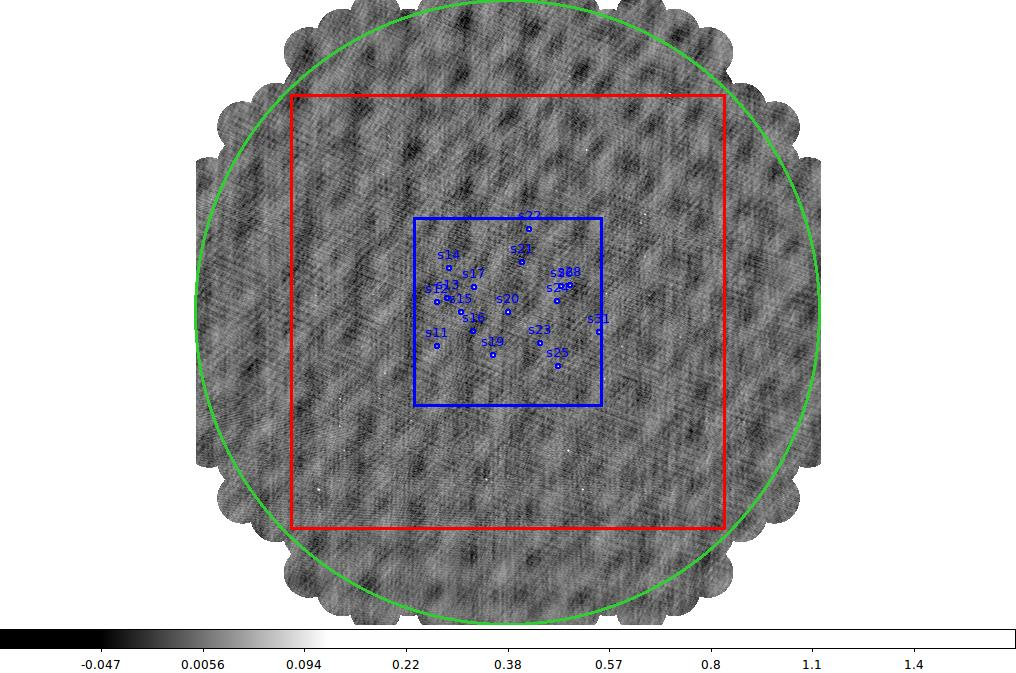

In [24]:
Image(filename='../test/2017-08/30/Images/q3cb65srcs.jpeg')

How neat is that?

#### Another quick test for sources inside 85% box

In [25]:
box85 = search_box(hdr['NAXIS1'], hdr['NAXIS2'], 0.85, w)
boxsize = box85[1,1] - box85[0,1]
box85, boxsize

(array([[ 41.04689012,  71.60849421],
        [ 42.95266075,  75.77418627],
        [ 25.80411424,  75.77418627],
        [ 27.70988487,  71.60849421]]), 4.165692055929668)

In [26]:
try:
    cur.execute(query, (box85[0,0], box85[0,1], box85[1,0], box85[1,1], box85[2,0], box85[2,1], box85[3,0], box85[3,1]))
    srcs = cur.fetchall()
except:
    conn.rollback()
    cur.execute(query, (box85[0,0], box85[0,1], box85[1,0], box85[1,1], box85[2,0], box85[2,1], box85[3,0], box85[3,1]))
    srcs = cur.fetchall()

print len(srcs), srcs

44 [[0, 41.039, 73.7914], [1, 41.0589, 73.8881], [2, 40.2936, 72.0361], [3, 39.8224, 72.661], [4, 39.889, 72.9225], [5, 39.6059, 72.4295], [6, 39.0879, 73.9505], [7, 38.6175, 72.958], [8, 39.0635, 75.1031], [9, 38.3664, 72.53], [10, 38.4858, 73.202], [11, 37.5215, 72.7633], [12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [19, 35.0742, 72.2214], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [28, 32.4657, 72.4905], [29, 32.2065, 74.0724], [30, 32.0597, 72.1139], [31, 31.4079, 75.3685], [32, 31.2676, 73.6094], [33, 31.1963, 73.1645], [34, 30.9672, 73.9812], [35, 30.5499, 73.4629], [36, 29.9211, 74.8912], [37, 29.5749, 74.6342], [38, 29.394, 74.7119], [39, 29.5255, 74.3054], [40, 29.5095, 74.3164], [41, 29.5022, 73.9371], [42, 29.13

In [27]:
with open('../test/2017-08/30/Images/q3csearchb85.reg', 'w') as f:
    f.write('global color=red width=2\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

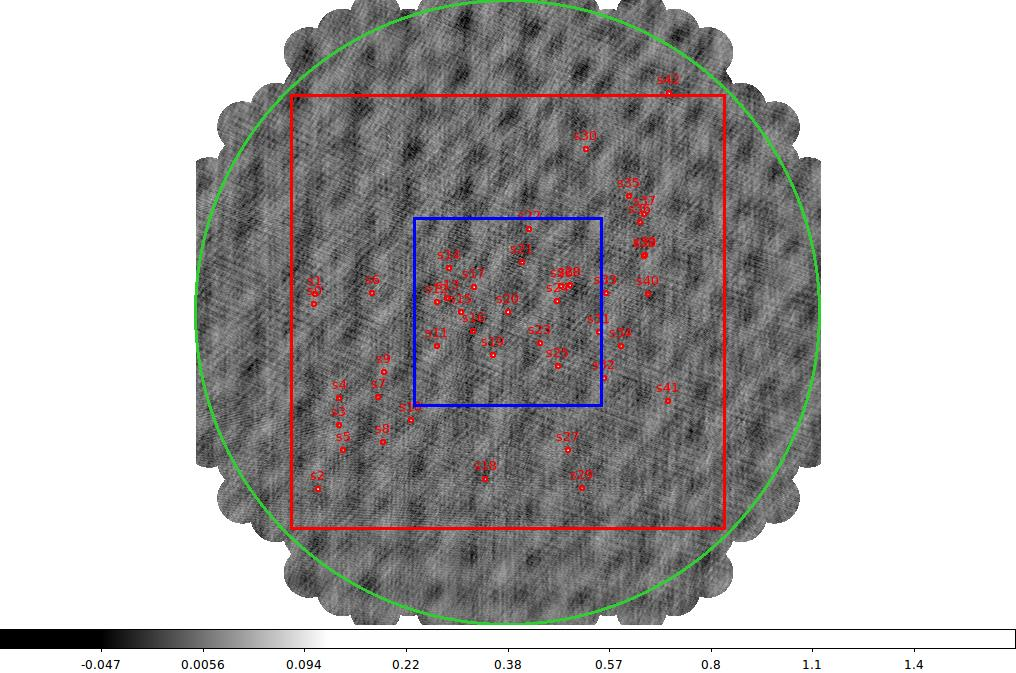

In [28]:
Image(filename='../test/2017-08/30/Images/q3cb85srcs.jpeg')

Pretty good, but the source in the top right probably shouldn't be included.

## Using a circular region

Since PyBDSF only allows control of the search region via a box, we have to actually crop the image into a circle if we want to search for sources only in a circular region.

In [29]:
data, hdr = fits.getdata('../test/2017-08/30/Images/6GHz.0217+738.IPln1.fits', header=True)

In [30]:
data.shape

(1, 1, 4337, 4337)

In [31]:
data = data.reshape(data.shape[2:])
data.shape

(4337, 4337)

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

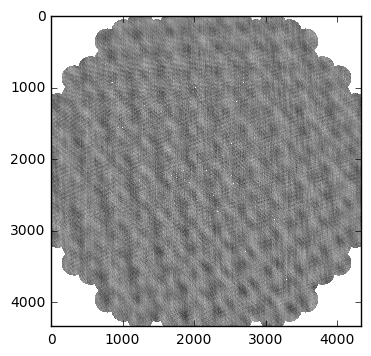

In [33]:
plt.imshow(data, cmap='gray', vmin=-0.1, vmax=0.1)

In [34]:
data[2000][2000]

0.012131399

**Test run with fake data**

In [35]:
arr = np.ones((7, 7))
arr

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.]])

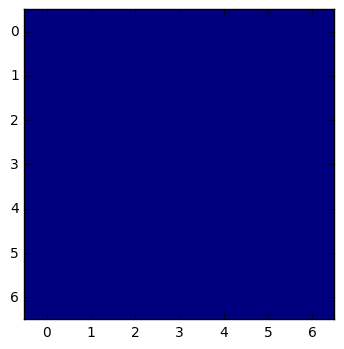

In [36]:
plt.imshow(arr)

In [37]:
def crop(arr, a, b, r):
    n = len(arr)
    y, x = np.ogrid[-a:n-a, -b:n-b]
    mask = x*x + y*y >= r*r
    arr[mask] = np.nan
    
    return arr

In [38]:
arr = crop(arr, 3, 3, 3)
arr

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,   1.,   1.,   1.,   1.,   1.,  nan],
       [ nan,   1.,   1.,   1.,   1.,   1.,  nan],
       [ nan,   1.,   1.,   1.,   1.,   1.,  nan],
       [ nan,   1.,   1.,   1.,   1.,   1.,  nan],
       [ nan,   1.,   1.,   1.,   1.,   1.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan]])

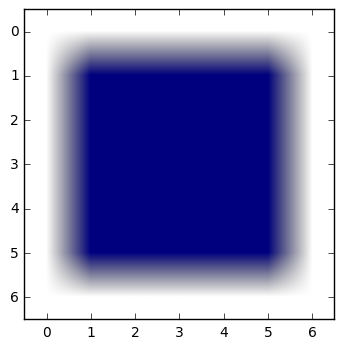

In [39]:
plt.imshow(arr)

**Back to our image**

In [40]:
hdr['CRPIX1'], hdr['CRPIX2'] # center pixels

(2169.0, 2169.0)

In [41]:
fov = hdr['NAXIS2'] * hdr['CDELT2']
fov

5.999554254

In [42]:
r = hdr['NAXIS2'] / 2.
r

2168.5

In [43]:
cdata = crop(data, hdr['CRPIX1'], hdr['CRPIX2'], r)

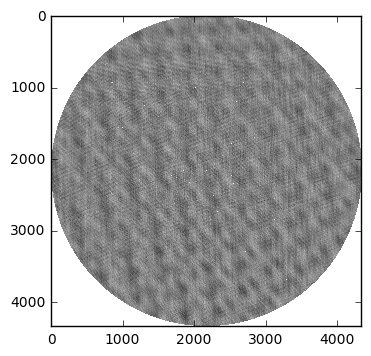

In [44]:
plt.imshow(cdata, cmap='gray', vmin=-0.1, vmax=0.1)

In [45]:
fits.writeto('../test/2017-08/30/Images/6GHz.0217+738.IPln1.crop.fits', cdata, header=hdr, clobber=True)

Test a range of sizes: 3 deg, 1.5 deg, and 0.5 deg

In [46]:
with open('../test/2017-08/30/Images/circles.reg', 'w') as f:
    f.write('fk5\n')
    f.write('circle(%f, %f, %fd) # color=green width=3\n' % (hdr['OBSRA'], hdr['OBSDEC'], fov/2.))
    f.write('circle(%f, %f, %fd) # color=red width=3\n' % (hdr['OBSRA'], hdr['OBSDEC'], 1.5))
    f.write('circle(%f, %f, %fd) # color=blue width=3\n' % (hdr['OBSRA'], hdr['OBSDEC'], 0.5))

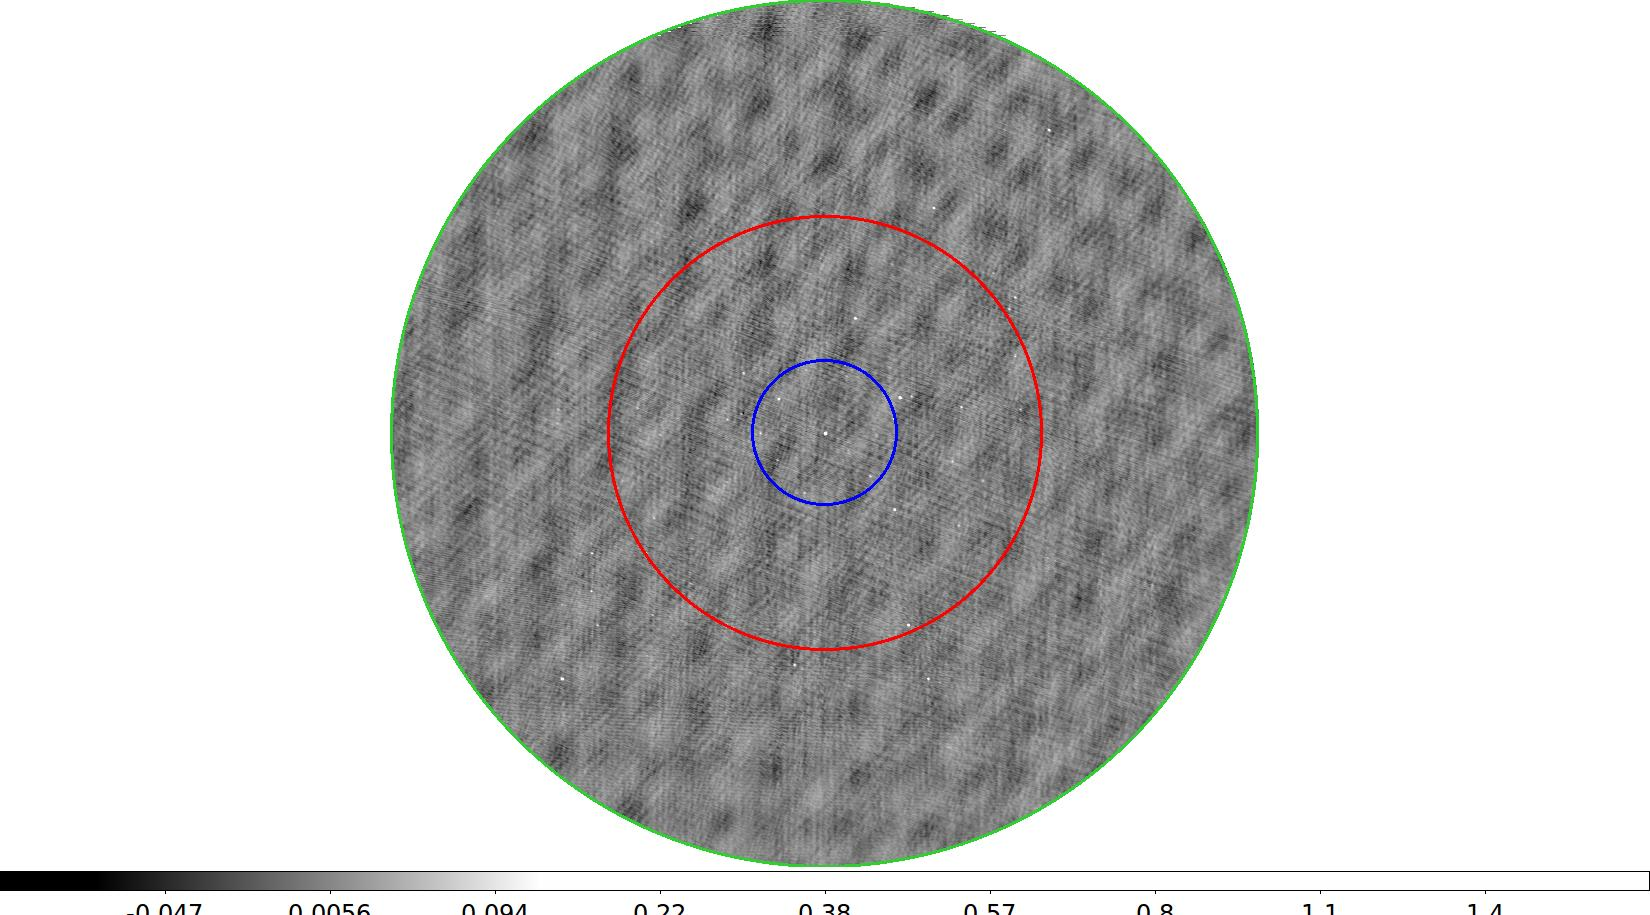

In [47]:
Image(filename='../test/2017-08/30/Images/circles.jpeg')

In [48]:
query1 = '''SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2 AND
    q3c_radial_query(ra, dec, %s, %s, %s)'''
query2 = '''SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2 AND
    q3c_join(%s, %s, ra, dec, %s)'''

In [49]:
%timeit cur.execute(query1, (hdr['OBSRA'], hdr['OBSDEC'], 3.0))

100 loops, best of 3: 3.08 ms per loop


In [50]:
%timeit cur.execute(query2, (hdr['OBSRA'], hdr['OBSDEC'], 3.0))

The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 351 µs per loop


Use query2 until tables get big!

In [51]:
srcs = cur.fetchall()
print len(srcs), srcs

44 [[0, 41.039, 73.7914], [1, 41.0589, 73.8881], [2, 40.2936, 72.0361], [3, 39.8224, 72.661], [4, 39.889, 72.9225], [5, 39.6059, 72.4295], [6, 39.0879, 73.9505], [7, 38.6175, 72.958], [8, 39.0635, 75.1031], [9, 38.3664, 72.53], [10, 38.4858, 73.202], [11, 37.5215, 72.7633], [12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [19, 35.0742, 72.2214], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [28, 32.4657, 72.4905], [29, 32.2065, 74.0724], [30, 32.0597, 72.1139], [31, 31.4079, 75.3685], [32, 31.2676, 73.6094], [33, 31.1963, 73.1645], [34, 30.9672, 73.9812], [35, 30.5499, 73.4629], [36, 29.9211, 74.8912], [37, 29.5749, 74.6342], [38, 29.394, 74.7119], [39, 29.5255, 74.3054], [40, 29.5095, 74.3164], [41, 29.5022, 73.9371], [42, 29.13

In [52]:
with open('../test/2017-08/30/Images/q3c3deg.reg', 'w') as f:
    f.write('global color=green width=2\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

In [53]:
cur.execute(query2, (hdr['OBSRA'], hdr['OBSDEC'], 1.5))
srcs = cur.fetchall()
print len(srcs), srcs

28 [[6, 39.0879, 73.9505], [7, 38.6175, 72.958], [10, 38.4858, 73.202], [11, 37.5215, 72.7633], [12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [28, 32.4657, 72.4905], [29, 32.2065, 74.0724], [32, 31.2676, 73.6094], [33, 31.1963, 73.1645], [34, 30.9672, 73.9812], [35, 30.5499, 73.4629], [39, 29.5255, 74.3054], [40, 29.5095, 74.3164], [41, 29.5022, 73.9371]]


In [54]:
with open('../test/2017-08/30/Images/q3c1pt5deg.reg', 'w') as f:
    f.write('global color=magenta width=2\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

In [55]:
cur.execute(query2, (hdr['OBSRA'], hdr['OBSDEC'], 0.5))
srcs = cur.fetchall()
print len(srcs), srcs

8 [[16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [24, 33.2815, 73.526], [25, 32.6595, 73.9222]]


In [56]:
with open('../test/2017-08/30/Images/q3c0pt5deg.reg', 'w') as f:
    f.write('global color=cyan width=2\n')
    f.write('fk5\n')
    for src in srcs:
        f.write('circle(%f, %f, 100.0") # text={s%s}\n' % (src[1], src[2], src[0]))

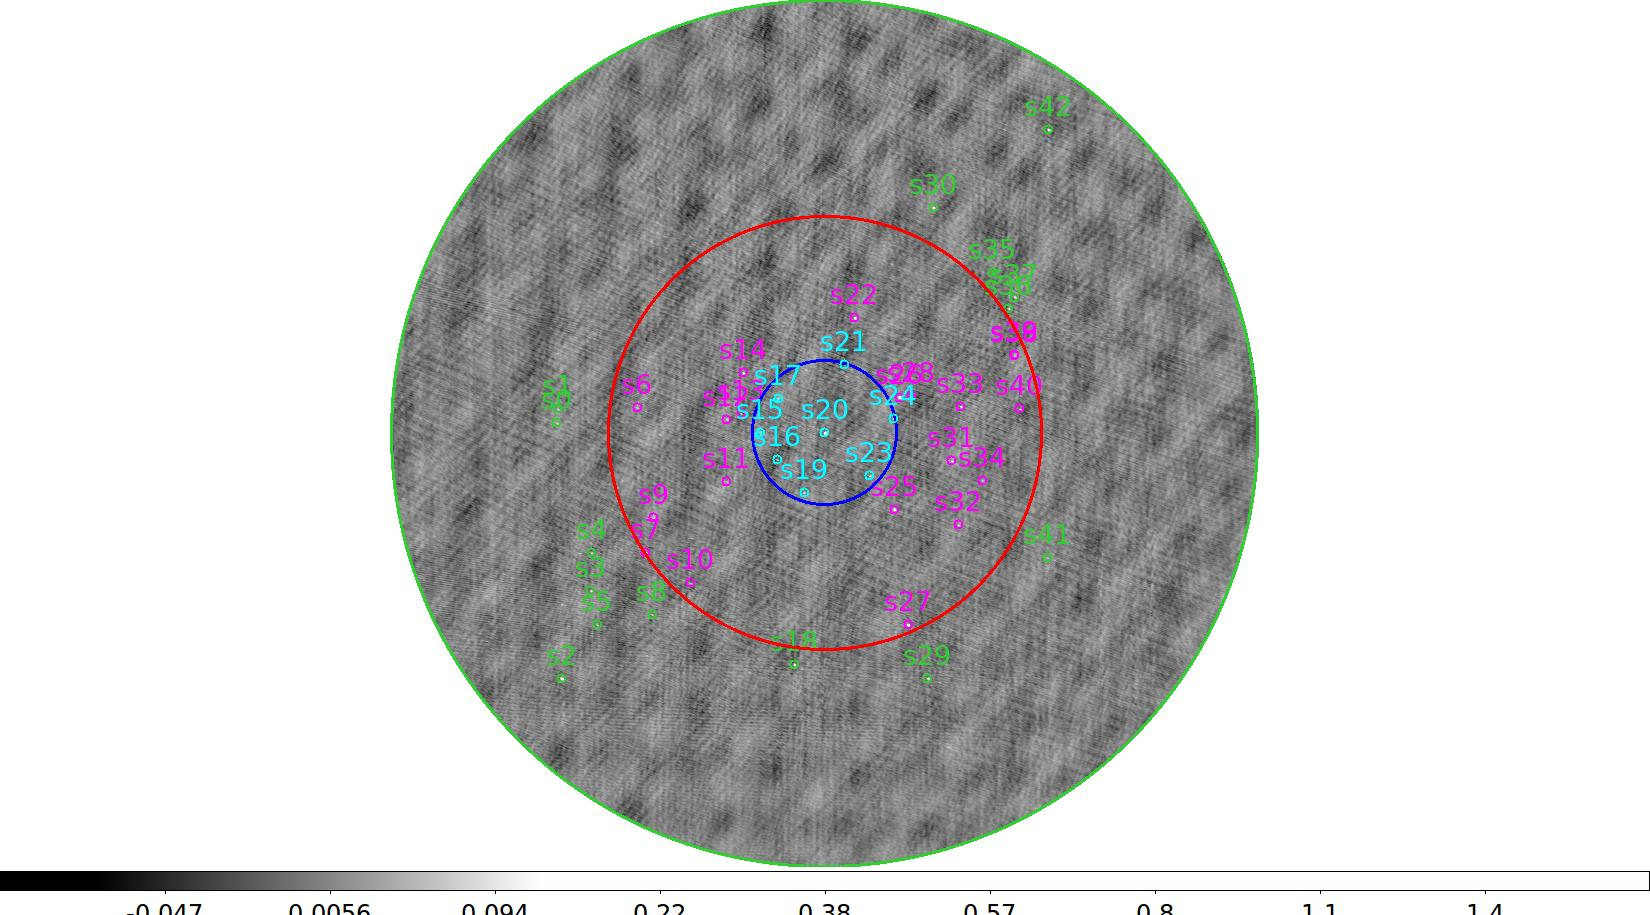

In [57]:
Image(filename='../test/2017-08/30/Images/q3ccircletest.jpeg')

## Timing comparison for queries

Cone search in SQL without indexing:

In [58]:
conn.rollback()

In [59]:
query = '''SELECT src_id, ra, dec FROM raw_source WHERE image_id = 2 AND
    2 * ASIN(SQRT(SIN(((%s-dec)/2)*%s) * SIN(((%s-dec)/2)*%s) + COS(%s*%s) * COS(dec*%s) 
    * SIN(((%s-ra)/2)*%s) * SIN(((%s-ra)/2)*%s))) <= %s'''

In [60]:
d2r = np.pi / 180.

In [61]:
%timeit cur.execute(query, (hdr['OBSDEC'], d2r, hdr['OBSDEC'], d2r, hdr['OBSDEC'], d2r, d2r, hdr['OBSRA'], d2r, hdr['OBSRA'], d2r, 3.0))

1000 loops, best of 3: 308 µs per loop


In [62]:
srcs = cur.fetchall()
print len(srcs), srcs

44 [[0, 41.039, 73.7914], [1, 41.0589, 73.8881], [2, 40.2936, 72.0361], [3, 39.8224, 72.661], [4, 39.889, 72.9225], [5, 39.6059, 72.4295], [6, 39.0879, 73.9505], [7, 38.6175, 72.958], [8, 39.0635, 75.1031], [9, 38.3664, 72.53], [10, 38.4858, 73.202], [11, 37.5215, 72.7633], [12, 36.7728, 73.4773], [13, 36.8264, 73.9077], [14, 36.4774, 73.95], [15, 36.4593, 74.233], [16, 35.9893, 73.8204], [17, 35.5523, 73.6379], [18, 35.5519, 74.0602], [19, 35.0742, 72.2214], [20, 34.8853, 73.4129], [21, 34.3782, 73.8257], [22, 33.8729, 74.3015], [23, 33.5972, 74.6212], [24, 33.2815, 73.526], [25, 32.6595, 73.9222], [26, 32.7098, 73.2927], [27, 32.4975, 74.0658], [28, 32.4657, 72.4905], [29, 32.2065, 74.0724], [30, 32.0597, 72.1139], [31, 31.4079, 75.3685], [32, 31.2676, 73.6094], [33, 31.1963, 73.1645], [34, 30.9672, 73.9812], [35, 30.5499, 73.4629], [36, 29.9211, 74.8912], [37, 29.5749, 74.6342], [38, 29.394, 74.7119], [39, 29.5255, 74.3054], [40, 29.5095, 74.3164], [41, 29.5022, 73.9371], [42, 29.13

In [63]:
cur.close()
conn.close()

### Measuring noise in beam size region

In [65]:
data, hdr = fits.getdata('../test/2017-08/30/Images/6GHz.0217+738.IPln1.fits', header=True)

In [67]:
data = data.reshape(data.shape[2:])
data.shape

(4337, 4337)

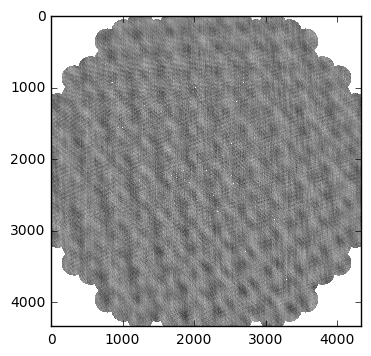

In [68]:
plt.imshow(data, cmap='gray', vmin=-0.1, vmax=0.1)

In [101]:
srcs[2]

[2, 40.2936, 72.0361]

In [71]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 34.378387495829998  73.825727777500006  
CRPIX : 2169.0  2169.0  
NAXIS    : 4337 4337

In [102]:
pixcoords = w.wcs_world2pix([srcs[2][1:]], 1)
pixcoords

array([[ 852.53798985,  940.83561964]])

In [126]:
# row = y
# column = x
x = int(round(pixcoords[0, 0]))
y = int(round(pixcoords[0, 1]))
x, y

(853, 941)

In [88]:
bmaj = hdr['BMAJ']
pixbm = bmaj / hdr['CDELT2']
print(bmaj*3600., pixbm)

(41.815836000000004, 8.396701611026051)


In [121]:
data[y, x], data[x, y]

(0.42229488, 0.0020412307)

y pixel (row) and then x pixel (column) is the correct ordering.

In [130]:
l = int(round(pixbm / 2.))
l

4

In [131]:
reg = data[y-l:y+l, x-l:x+l]
reg

array([[ 0.239907  ,  0.29386893,  0.34353763,  0.37531969,  0.377211  ,
         0.34777886,  0.29717058,  0.23924965],
       [ 0.28656551,  0.3479616 ,  0.4021664 ,  0.43388811,  0.43150634,
         0.39526394,  0.33656666,  0.26960391],
       [ 0.31861266,  0.38247806,  0.43672174,  0.46581146,  0.45932868,
         0.41879898,  0.35579398,  0.28405955],
       [ 0.33139396,  0.39204097,  0.4416571 ,  0.46589851,  0.45600691,
         0.41410863,  0.35098344,  0.27938342],
       [ 0.32351255,  0.37571359,  0.41682416,  0.43471509,  0.42229488,
         0.38160485,  0.32206523,  0.25517389],
       [ 0.29661512,  0.3367492 ,  0.36708596,  0.37809971,  0.36401913,
         0.32635555,  0.27309853,  0.21446919],
       [ 0.25467977,  0.28146854,  0.30078459,  0.30546331,  0.29055721,
         0.25698251,  0.21162744,  0.16351126],
       [ 0.20324133,  0.21782884,  0.22776911,  0.22757468,  0.21272554,
         0.18382552,  0.14714725,  0.11053016]], dtype=float32)

In [132]:
np.std(reg)

0.08507745